In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from graphviz import Digraph

import zipfile

List of Causal Effects:

Earth quake affects monetary policy https://www.sciencedirect.com/science/article/pii/S0164070418304026

Dynamics of Tokyo Electric Power Company and the Nikkei https://www.jstor.org/stable/26418774

Global Seismic Data: https://www.globalquakemodel.org/product/global-seismic-hazard-map

Global Earthquake Exposure Model (Data for exposure model): https://github.com/gem/global_exposure_model

Global Earthquake Vulnerability Model (Data for vulnerability model): https://github.com/gem/global_vulnerability_model/

Japanese Municipal Bonds (quarterly): https://needs.nikkei.co.jp/services/jsprice/#sample

Japanese Municipal Bonds (daily): https://www.mcnnns77.net/market-data

Mesh code and prefectures: https://www.stat.go.jp/data/mesh/m_itiran.html

Earthquake probability (Seismic Hazard Map): https://www.j-shis.bosai.go.jp/map/JSHIS2/download.html?lang=en (first four columns)

Earthquake probability documentation:
- https://www.j-shis.bosai.go.jp/map/JSHIS2/man/en/man_point_search.html
- https://www.j-shis.bosai.go.jp/map/JSHIS2/man/en/man_map_operation_c.html

How to calculate latitude and longitude from MeshCode (documentation in Japanese):
- https://www.stat.go.jp/data/mesh/pdf/gaiyo1.pdf#page=7

Total number of bond issued from 2002 for each city per year:
- https://www.soumu.go.jp/iken/kessan_jokyo_2.html

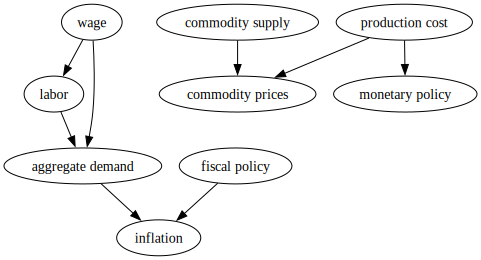

In [30]:
## TODO: make changes to the DAG
g = Digraph()
g.edge("wage", "labor")
g.edge("labor", "aggregate demand")
g.edge("wage", "aggregate demand")
g.edge("aggregate demand", "inflation")
g.edge("commodity supply", "commodity prices")
g.edge("production cost", "commodity prices")
g.edge("production cost", "monetary policy")
g.edge("fiscal policy", "inflation")
g

data sources:
prices.csv and yields.csv are taken from https://www.kaggle.com/datasets/everget/government-bonds/

In [31]:
fukushima = pd.read_csv("data/Fukushima.csv")
fukushima['Date'] = pd.to_datetime(fukushima['Date'], unit='s')
fukushima['Date'] = fukushima['Date'].dt.strftime('%Y/%m/%d')
fukushima.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2008/03/25,0.009841,0.009718,NaN,NaN,NaN,NaN
1,2008/03/26,0.009944,0.009716,NaN,NaN,NaN,NaN
2,2008/03/27,0.009930,0.009596,NaN,NaN,NaN,NaN
3,2008/03/28,0.009799,0.009550,NaN,NaN,NaN,NaN
4,2008/03/31,0.009808,0.009531,NaN,NaN,NaN,NaN


In [32]:
hokkaido = pd.read_csv("data/Hokkaido.csv")
hokkaido['Date'] = pd.to_datetime(hokkaido['Date'], unit='s')
hokkaido['Date'] = hokkaido['Date'].dt.strftime('%Y/%m/%d')
hokkaido.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2002/08/01,NaN,0.005737,0.010144,0.014735,NaN,NaN
1,2002/08/02,NaN,0.005582,0.009971,0.014602,NaN,NaN
2,2002/08/05,NaN,0.005497,0.009733,0.014427,NaN,NaN
3,2002/08/06,NaN,0.005658,0.009819,0.014577,NaN,NaN
4,2002/08/07,NaN,0.005527,0.009627,0.014324,NaN,NaN


In [33]:
osaka = pd.read_csv("data/Osaka.csv")
osaka['Date'] = pd.to_datetime(osaka['Date'], unit='s')
osaka['Date'] = osaka['Date'].dt.strftime('%Y/%m/%d')
osaka.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2002/08/01,0.002755,0.005864,0.010159,0.014447,NaN,NaN
1,2002/08/02,0.002749,0.005712,0.010003,0.014313,NaN,NaN
2,2002/08/05,0.002846,0.005614,0.009722,0.014199,NaN,NaN
3,2002/08/06,0.002925,0.005768,0.009814,0.014348,NaN,NaN
4,2002/08/07,0.002912,0.005657,0.009613,0.014111,NaN,NaN


In [34]:
kumamoto = pd.read_csv("data/Kumamoto.csv")
kumamoto['Date'] = pd.to_datetime(kumamoto['Date'], unit='s')
kumamoto['Date'] = kumamoto['Date'].dt.strftime('%Y/%m/%d')
kumamoto.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2007/07/30,0.012411,0.015157,0.017088,0.019526,NaN,NaN
1,2007/07/31,0.012421,0.015117,0.017032,0.019452,NaN,NaN
2,2007/08/01,0.012160,0.014759,0.016673,0.019113,NaN,NaN
3,2007/08/02,0.012325,0.015075,0.017072,0.019588,NaN,NaN
4,2007/08/03,0.012272,0.014945,0.016880,0.019389,NaN,NaN


In [35]:
fukuoka = pd.read_csv("data/Fukuoka.csv")
fukuoka['Date'] = pd.to_datetime(fukuoka['Date'], unit='s')
fukuoka['Date'] = fukuoka['Date'].dt.strftime('%Y/%m/%d')
fukuoka.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2002/08/01,0.002624,0.004999,0.009111,0.013938,NaN,NaN
1,2002/08/02,0.002648,0.004851,0.008926,0.013840,NaN,NaN
2,2002/08/05,0.002666,0.004621,0.008623,0.013748,NaN,NaN
3,2002/08/06,0.002708,0.004750,0.008706,0.013932,NaN,NaN
4,2002/08/07,0.002636,0.004606,0.008496,0.013738,NaN,NaN


In [36]:
kanagawa = pd.read_csv("data/Kanagawa.csv")
kanagawa['Date'] = pd.to_datetime(kanagawa['Date'], unit='s')
kanagawa['Date'] = kanagawa['Date'].dt.strftime('%Y/%m/%d')
kanagawa.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2002/08/01,NaN,0.005020,0.009180,0.013882,NaN,NaN
1,2002/08/02,NaN,0.004856,0.009000,0.013751,NaN,NaN
2,2002/08/05,NaN,0.004677,0.008682,0.013650,NaN,NaN
3,2002/08/06,NaN,0.004837,0.008738,0.013814,NaN,NaN
4,2002/08/07,NaN,0.004700,0.008540,0.013575,NaN,NaN


In [37]:
hyogo = pd.read_csv("data/Hyogo.csv")
hyogo['Date'] = pd.to_datetime(hyogo['Date'], unit='s')
hyogo['Date'] = hyogo['Date'].dt.strftime('%Y/%m/%d')
hyogo.head()

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year
0,2002/08/01,0.002863,0.005324,0.009906,0.014302,NaN,NaN
1,2002/08/02,0.002820,0.005190,0.009755,0.014185,NaN,NaN
2,2002/08/05,0.002815,0.005127,0.009475,0.014299,NaN,NaN
3,2002/08/06,0.002873,0.005302,0.009555,0.014538,NaN,NaN
4,2002/08/07,0.002856,0.005186,0.009350,0.014345,NaN,NaN


In [38]:
# Specify the path to your zip file and the name of the CSV file within the zip file
FILENAME = "P-Y2010-MAP-AVR-TTL_MTTL"
COLUMNS = ['# CODE', ' T30_I45_PS', ' T30_I50_PS', ' T30_I55_PS', ' T30_I60_PS']
zip_file_path = 'data/' + FILENAME + '.zip'
csv_file_name = FILENAME + '.csv'
rows_to_skip = 8

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the CSV file
    with zip_ref.open(csv_file_name) as file:
        # Read the CSV file into a DataFrame
        seismic_data = pd.read_csv(file, skiprows = rows_to_skip)[COLUMNS]
seismic_data.head()

,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS
0,3036500524N,0.000000,0.000000,0.000000,0.000000
1,3036500542N,0.000000,0.000000,0.000000,0.000000
2,3036500623N,0.000000,0.000000,0.000000,0.000000
3,3036500641N,0.000000,0.000000,0.000000,0.000000
4,3622572534N,0.797367,0.454856,0.176731,0.034857


In [39]:
# TODO: check this is correct

# def get_latlon(meshCode):

#     #Convert to string
#     meshCode = str(meshCode)

#     #Calculation for primary mesh
#     code_first_two = meshCode[0:2]
#     code_last_two = meshCode[2:4]
#     code_first_two = int(code_first_two)
#     code_last_two = int(code_last_two)
#     lat  = code_first_two * 2 / 3
#     lon = code_last_two + 100

#     if len(meshCode) > 4:
#         #Calculation for secondary mesh
#         if len(meshCode) >= 6:
#             code_fifth = meshCode[4:5]
#             code_sixth = meshCode[5:6]
#             code_fifth = int(code_fifth)
#             code_sixth = int(code_sixth)
#             lat += code_fifth * 2 / 3 / 8
#             lon += code_sixth / 8

#         #Calculation for 3rd mesh
#         if len(meshCode) >= 8:
#             code_seventh = meshCode[6:7]
#             code_eighth = meshCode[7:8]
#             code_seventh = int(code_seventh)
#             code_eighth = int(code_eighth)
#             lat += code_seventh * 2 / 3 / 8 / 10
#             lon += code_eighth / 8 / 10
            
#         # 1/Calculation for 2 mesh
#         if len(meshCode) >= 9:
#             code_nineth = meshCode[8:9]
#             code_nineth = int(code_nineth)
#             if code_nineth % 2 == 0:
#                 lon += 0.00138888
#             if code_nineth > 2:
#                 lat += 0.00416666
                
#         # 1/Calculation for 4 mesh
#         if len(meshCode) >= 10:
#             code_tenth = meshCode[9:10]
#             code_tenth = int(code_tenth)
#             if code_tenth % 2 == 0:
#                 lon += 0.00138888 / 2
#             if code_tenth > 2:
#                 lat += 0.00416666 / 2
        
#         # 1/Calculation for 8 mesh
#         if len(meshCode) >= 11:
#             code_eleventh = meshCode[10:11]
#             code_eleventh = int(code_eleventh)
#             if code_eleventh % 2 == 0:
#                 lon += 0.00138888 / 2 / 2
#             if code_eleventh > 2:
#                 lat += 0.00416666 / 2 / 2
            
#     return lat, lon
# seismic_data["lat"] = seismic_data[COLUMNS[0]].apply(lambda x: get_latlon(x[:-1])[0])
# seismic_data["lon"] = seismic_data[COLUMNS[0]].apply(lambda x: get_latlon(x[:-1])[1])
# get_latlon(seismic_data[COLUMNS[0]][:-1])[1]
# seismic_data["lon"] = get_latlon(seismic_data[COLUMNS[0]][:-1])[0]
seismic_data.head()

,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS
0,3036500524N,0.000000,0.000000,0.000000,0.000000
1,3036500542N,0.000000,0.000000,0.000000,0.000000
2,3036500623N,0.000000,0.000000,0.000000,0.000000
3,3036500641N,0.000000,0.000000,0.000000,0.000000
4,3622572534N,0.797367,0.454856,0.176731,0.034857


In [40]:
MESHCODE = "MeshCode"
fukushima_mesh = pd.read_csv("data/FukushimaMesh.csv")
fukushima_mesh_codes = set(fukushima_mesh[MESHCODE].unique())

hokkaido_mesh = pd.read_csv("data/HokkaidoMesh.csv")
hokkaido_mesh_codes = set(hokkaido_mesh[MESHCODE].unique())

kumamoto_mesh = pd.read_csv("data/KumamotoMesh.csv")
kumamoto_mesh_codes = set(kumamoto_mesh[MESHCODE].unique())

osaka_mesh = pd.read_csv("data/OsakaMesh.csv")
osaka_mesh_codes = set(osaka_mesh[MESHCODE].unique())

seismic_data["inFukushima"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(fukushima_mesh_codes).astype(int)
seismic_data["inHokkaido"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(hokkaido_mesh_codes).astype(int)
seismic_data["inKumamoto"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(kumamoto_mesh_codes).astype(int)
seismic_data["inOsaka"] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(osaka_mesh_codes).astype(int)

In [41]:
fukushima_seismic_data = seismic_data.query("inFukushima == 1")
print(f"size of fukushima seismic data is {len(fukushima_seismic_data)}")
fukushima_seismic_data.head()

size of fukushima seismic data is 220027


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
3269610,5539229711N,0.097216,0.01156,0.001758,0.00013,1,0,0,0
3269611,5539229712N,0.097216,0.01156,0.001758,0.00013,1,0,0,0
3269612,5539229713N,0.097216,0.01156,0.001758,0.00013,1,0,0,0
3269613,5539229714N,0.097216,0.01156,0.001758,0.00013,1,0,0,0
3269614,5539229721N,0.097216,0.01156,0.001758,0.00013,1,0,0,0


In [42]:
hokkaido_seismic_data = seismic_data.query("inHokkaido == 1")
print(f"size of hokkaido seismic data is {len(hokkaido_seismic_data)}")
hokkaido_seismic_data.head()

size of hokkaido seismic data is 1421552


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
4523029,6239062333N,0.084855,0.021721,0.004655,0.000661,0,1,0,0
4523030,6239062342N,0.084855,0.021721,0.004655,0.000661,0,1,0,0
4523031,6239062344N,0.084855,0.021721,0.004655,0.000661,0,1,0,0
4523032,6239062411N,0.084571,0.021468,0.004548,0.000637,0,1,0,0
4523033,6239062412N,0.084571,0.021468,0.004548,0.000637,0,1,0,0


In [43]:
kumamoto_seismic_data = seismic_data.query("inKumamoto == 1")
print(f"size of kumamoto seismic data is {len(kumamoto_seismic_data)}")
kumamoto_seismic_data.head()

size of kumamoto seismic data is 114333


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
203372,4829177722N,0.224769,0.060069,0.011360,0.001092,0,0,1,0
203373,4829177811N,0.226232,0.060223,0.011411,0.001106,0,0,1,0
203374,4829177813N,0.226232,0.060223,0.011411,0.001106,0,0,1,0
203375,4829270532N,0.218038,0.057871,0.010773,0.001011,0,0,1,0
203378,4829271611N,0.218041,0.057352,0.010641,0.001001,0,0,1,0


In [44]:
osaka_seismic_data = seismic_data.query("inOsaka == 1")
print(f"size of osaka seismic data is {len(osaka_seismic_data)}")
osaka_seismic_data.head()

size of osaka seismic data is 31548


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inFukushima,inHokkaido,inKumamoto,inOsaka
1280697,5135302811N,0.708822,0.25107,0.02033,0.000309,0,0,0,1
1280698,5135302812N,0.708822,0.25107,0.02033,0.000309,0,0,0,1
1280699,5135302813N,0.708822,0.25107,0.02033,0.000309,0,0,0,1
1280700,5135302814N,0.708822,0.25107,0.02033,0.000309,0,0,0,1
1280701,5135302821N,0.708822,0.25107,0.02033,0.000309,0,0,0,1
